In [1]:
# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Parse and sort Spark applications' log by execution start time
from sparklogstats import LogParser
parser = LogParser()

import glob
apps = []
for log in glob.glob('data/app-*'):
    parser.parse_file(log)
    apps.append(parser.app)
apps.sort(key=lambda x: x.start)

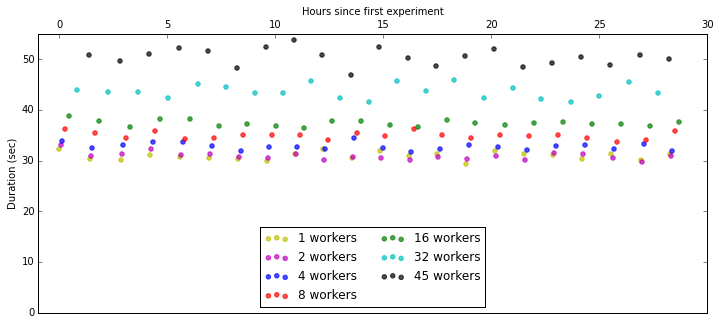

In [3]:
# Scatter plot with all durations in y and start time in x
# Uses different colors for each worker amount

# Transform start timestamp into hours since first experiment
def scale_x(x):
    hour_in_ms = 1000 * 60 * 60
    start_time = apps[0].start
    return (x - start_time) / hour_in_ms

# Moving x axis to the top
_, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

worker_amounts = sorted(set((len(app.workers) for app in apps)))
colors = ['y', 'm', 'b', 'r', 'g', 'c', 'k']
for worker_amount, color in zip(worker_amounts, colors):
    w_apps = [app for app in apps if len(app.workers) == worker_amount]
    xs = [scale_x(app.start) for app in w_apps]
    ys = [app.duration/1000 for app in w_apps]
    label = '{:d} workers'.format(worker_amount)
    plt.scatter(xs, ys, color=color, alpha=0.7, label=label)

plt.legend(loc='lower center', ncol=2)
plt.xlim(-1, 30)
plt.ylim(0, 55)
plt.xlabel('Hours since first experiment')
plt.ylabel('Duration (sec)')
plt.show()